In [1]:
pip install tensorflow numpy opencv-python matplotlib scikit-learn


  Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.


In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_auc_score


In [1]:
import os
import cv2
import numpy as np

# Function to load and preprocess images
def load_images(directory, img_size=(224, 224)):
    images = []
    for file in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images).reshape(-1, img_size[0], img_size[1], 1)

# Load all images from a single dataset folder
dataset_images = load_images("C:/Users/kasar/Desktop/AI in Healthcare/PROJECT DATASET/ULTRASOUND/Ultrasound_Model/KAGGLE/Dataset2/")
print(f"Total images loaded: {len(dataset_images)}")


Total images loaded: 999


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Autoencoder Model
input_img = Input(shape=(224, 224, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder on all images
autoencoder.fit(dataset_images, dataset_images, epochs=50, batch_size=16, shuffle=True)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 615ms/step - loss: 0.0900
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 688ms/step - loss: 0.0546
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 695ms/step - loss: 0.0542
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 910ms/step - loss: 0.0542
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 714ms/step - loss: 0.0553
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 632ms/step - loss: 0.0542
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 662ms/step - loss: 0.0531
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 601ms/step - loss: 0.0536
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 629ms/step - loss: 0.0540
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 605ms/step - loss: 0.0535
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 673ms/step - loss: 0.0528
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 602ms/step - loss: 0.0528
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 589ms/step - loss: 0.0544
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 577ms/step - loss: 0.0541
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 

In [3]:
# Get reconstructed images
reconstructed_images = autoencoder.predict(dataset_images)

# Compute reconstruction error (Mean Absolute Error)
errors = np.mean(np.abs(reconstructed_images - dataset_images), axis=(1, 2, 3))

# Set a threshold: Top 5% images with highest error are considered abnormal
threshold = np.percentile(errors, 95)
anomalies = errors > threshold

# Print number of anomalies detected
print(f"Detected {np.sum(anomalies)} possible abnormal images out of {len(dataset_images)}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 410ms/step
Detected 50 possible abnormal images out of 999


In [4]:
import numpy as np

# Compute Mean Squared Error (MSE) for reconstruction loss
mse_loss = np.mean(np.square(reconstructed_images - dataset_images), axis=(1, 2, 3))

# Print average reconstruction loss
print(f"Average Reconstruction Loss: {np.mean(mse_loss):.6f}")


Average Reconstruction Loss: 0.054019


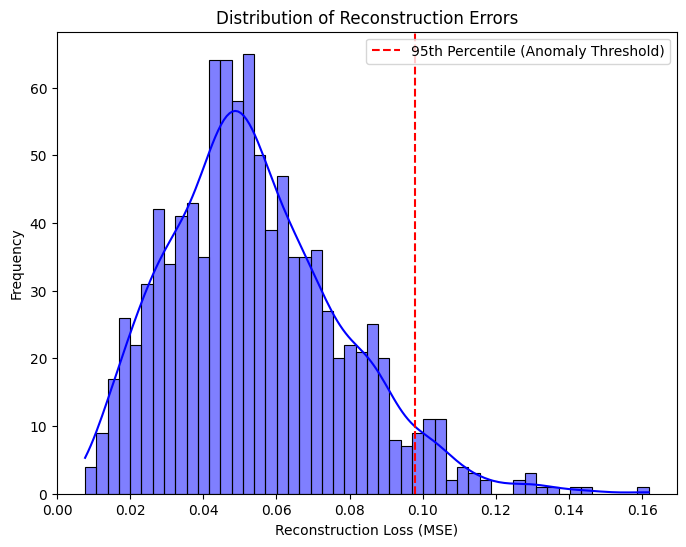

Anomaly Detection Threshold: 0.097839


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram of reconstruction errors
plt.figure(figsize=(8, 6))
sns.histplot(mse_loss, bins=50, kde=True, color='blue')
plt.axvline(np.percentile(mse_loss, 95), color='red', linestyle='dashed', label="95th Percentile (Anomaly Threshold)")
plt.xlabel("Reconstruction Loss (MSE)")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.legend()
plt.show()

# Set threshold at 95th percentile
threshold = np.percentile(mse_loss, 95)
print(f"Anomaly Detection Threshold: {threshold:.6f}")


In [7]:
# Flag images as anomalies
anomalies = mse_loss > threshold

# Count detected anomalies
num_anomalies = np.sum(anomalies)
print(f"🚨 Detected {num_anomalies} anomalies out of {len(mse_loss)} total images.")


🚨 Detected 50 anomalies out of 999 total images.


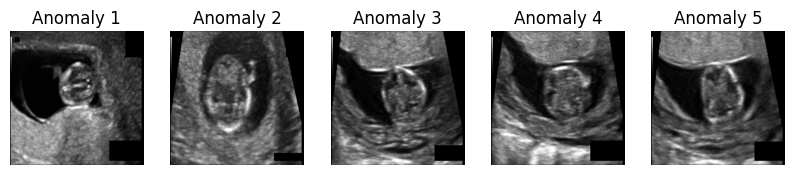

In [8]:
import matplotlib.pyplot as plt

# Get indices of detected anomalies
anomaly_indices = np.where(anomalies)[0]

# Show first 5 anomalies
plt.figure(figsize=(10, 5))
for i, idx in enumerate(anomaly_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(dataset_images[idx].reshape(224, 224), cmap='gray')
    plt.title(f"Anomaly {i+1}")
    plt.axis("off")
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# Compute AUC-ROC Score
auc_score = roc_auc_score(y_true, mse_loss)
print(f"AUC-ROC Score: {auc_score:.4f}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, mse_loss)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [9]:
import os
import shutil
import pandas as pd
from tqdm import tqdm  # For progress bars

def organize_ultrasound_data(base_dir):
    """
    Organizes fetal ultrasound images into normal/abnormal folders based on CSV labels.
    Creates new Train1, Valid1, Test1 directories to avoid modifying original data.
    """
    # Define paths
    original_dirs = {
        'train': os.path.join(base_dir, 'train'),
        'valid': os.path.join(base_dir, 'valid'),
        'test': os.path.join(base_dir, 'test')
    }

    new_dirs = {
        'train': 'Train1',
        'valid': 'Valid1',
        'test': 'Test1'
    }

    # Create new directory structure
    for new_dir in new_dirs.values():
        for category in ['normal', 'abnormal']:
            os.makedirs(os.path.join(base_dir, new_dir, category), exist_ok=True)

    # Process each dataset split
    for split, original_path in original_dirs.items():
        csv_path = os.path.join(original_path, '_classes.csv')
        if not os.path.exists(csv_path):
            print(f"Warning: CSV not found at {csv_path}")
            continue

        df = pd.read_csv(csv_path)
        print(f"\nProcessing {split} set ({len(df)} images)...")

        normal_count = 0
        abnormal_count = 0
        missing_count = 0

        # Process with progress bar
        for _, row in tqdm(df.iterrows(), total=len(df)):
            # Handle different path formats in CSV
            src_path = os.path.join(original_path, os.path.basename(row['filename']))

            if not os.path.exists(src_path):
                missing_count += 1
                continue

            # Determine abnormality (CSP or LV present)
            is_abnormal = (row['CSP'] == 1) or (row['LV'] == 1)
            category = 'abnormal' if is_abnormal else 'normal'

            # Set destination path
            dest_path = os.path.join(base_dir, new_dirs[split], category, os.path.basename(row['filename']))

            # Copy image (with overwrite protection)
            if not os.path.exists(dest_path):
                shutil.copy(src_path, dest_path)

            # Update counters
            if is_abnormal:
                abnormal_count += 1
            else:
                normal_count += 1

        print(f"Results for {new_dirs[split]}:")
        print(f"  Normal images: {normal_count}")
        print(f"  Abnormal images: {abnormal_count}")
        print(f"  Missing files: {missing_count}")

# Run the organization
organize_ultrasound_data('C:/Users/kasar/Desktop/AI in Healthcare/PROJECT DATASET/ULTRASOUND/Ultrasound_Model/KAGGLE/')


Processing train set (5751 images)...


100%|██████████| 5751/5751 [01:14<00:00, 77.48it/s] 


Results for Train1:
  Normal images: 2270
  Abnormal images: 3480
  Missing files: 1

Processing valid set (554 images)...


100%|██████████| 554/554 [00:06<00:00, 86.50it/s] 


Results for Valid1:
  Normal images: 213
  Abnormal images: 341
  Missing files: 0

Processing test set (269 images)...


100%|██████████| 269/269 [00:03<00:00, 82.29it/s]

Results for Test1:
  Normal images: 117
  Abnormal images: 152
  Missing files: 0


In [10]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory

# Dataset path
dataset_path = r"C:/Users/kasar/Desktop/AI in Healthcare/PROJECT DATASET/ULTRASOUND/Ultrasound_Model/KAGGLE/"

# Image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Load training dataset (only normal images for training the autoencoder)
train_dataset = image_dataset_from_directory(
    os.path.join(dataset_path, "Train1"),
    labels="inferred",
    label_mode=None,  # No labels needed for autoencoder
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

# Normalize images (scale to [0,1])
train_dataset = train_dataset.map(lambda x: x / 255.0)

# Load validation and test datasets (for evaluation)
valid_dataset = image_dataset_from_directory(
    os.path.join(dataset_path, "Valid1"),
    labels="inferred",
    label_mode=None,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(lambda x: x / 255.0)

test_dataset = image_dataset_from_directory(
    os.path.join(dataset_path, "Test1"),
    labels="inferred",
    label_mode=None,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
).map(lambda x: x / 255.0)


Found 5750 files.
Found 554 files.
Found 269 files.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# Define autoencoder
input_img = Input(shape=(224, 224, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 224, 224, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Debug: Check first batch of training dataset
for batch in train_dataset.take(1):
    print("Batch shape:", batch.shape)


Batch shape: (16, 224, 224, 1)


In [19]:
# Check the number of batches and the shape of data to verify loading
print(f"Train data batches: {len(train_dataset)}")
print(f"Validation data batches: {len(valid_dataset)}")

# Check the shape of a single batch
x_batch, _ = next(train_dataset)
print(f"Shape of a single batch from train_data: {x_batch.shape}")
x_batch, _ = next(valid_dataset)
print(f"Shape of a single batch from valid_data: {x_batch.shape}")

# Now train the autoencoder
autoencoder.fit(train_dataset, epochs=50, validation_data=valid_dataset)


Train data batches: 360
Validation data batches: 35


TypeError: '_MapDataset' object is not an iterator

In [16]:

# Train the model
autoencoder.fit(train_dataset, epochs=50, validation_data=valid_dataset)

Epoch 1/50


ValueError: None values not supported.

In [22]:
# Check if data is being loaded correctly by inspecting the directories
train_dir = os.path.join(base_dir, 'Train1')
valid_dir = os.path.join(base_dir, 'Valid1')
test_dir = os.path.join(base_dir, 'Test1')

# List files in the directories to ensure the data exists
print("Train directory files:", os.listdir(train_dir))
print("Validation directory files:", os.listdir(valid_dir))
print("Test directory files:", os.listdir(test_dir))

# Now check if the data generators are loading correctly
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=True
)

valid_data = test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False
)

# Check the number of batches and shapes
print(f"Train data batches: {len(train_data)}")
print(f"Validation data batches: {len(valid_data)}")
print(f"Test data batches: {len(test_data)}")

# Check if data exists in each batch (with class_mode=None, only image data is returned)
x_batch = next(train_data)
print(f"Shape of a single batch from train_data: {x_batch.shape}")

x_batch = next(valid_data)
print(f"Shape of a single batch from valid_data: {x_batch.shape}")

x_batch = next(test_data)
print(f"Shape of a single batch from test_data: {x_batch.shape}")



Train directory files: ['abnormal', 'normal']
Validation directory files: ['abnormal', 'normal']
Test directory files: ['abnormal', 'normal']
Found 5750 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Found 269 images belonging to 2 classes.
Train data batches: 360
Validation data batches: 35
Test data batches: 17
Shape of a single batch from train_data: (16, 224, 224, 1)
Shape of a single batch from valid_data: (16, 224, 224, 1)
Shape of a single batch from test_data: (16, 224, 224, 1)


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directory for training data (Train1 folder)
train_dir = 'C:/Users/kasar/Desktop/AI in Healthcare/PROJECT DATASET/ULTRASOUND/Ultrasound_Model/KAGGLE/Train1'

# Image parameters
img_size = (224, 224)  # Target size for images
batch_size = 16

# Custom data generator to handle .png images
def custom_image_generator(directory, batch_size, target_size=(224, 224)):
    # List all files in the directory, filtering for .png files
    image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if fname.endswith('.png')]
    
    while True:
        # Shuffle the images at each epoch
        np.random.shuffle(image_paths)
        batch_images = []
        
        # Loop through the image paths and load the images
        for i in range(batch_size):
            if i >= len(image_paths):  # If fewer images are remaining than the batch size
                break
            
            img = load_img(image_paths[i], target_size=target_size, color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            batch_images.append(img_array)
        
        if len(batch_images) < batch_size:  # Pad the batch if it has fewer images
            batch_images.extend([np.zeros(target_size + (1,))] * (batch_size - len(batch_images)))
        
        # Yield both the input and target as the same batch of images
        yield np.array(batch_images), np.array(batch_images)

# Create the custom generator for training
train_data_gen = custom_image_generator(train_dir, batch_size=batch_size)

# Check the shape of the first batch
x_batch, _ = next(train_data_gen)
print(f"Shape of a single batch from train_data: {x_batch.shape}")

# Autoencoder architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(224, 224, 1)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Build and compile the autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')

    return autoencoder

# Build the autoencoder model
autoencoder = build_autoencoder()

# Train the model using the custom data generator
autoencoder.fit(train_data_gen, epochs=50, steps_per_epoch=360)

# Save the model after training (optional)
autoencoder.save('autoencoder_model.h5')


Shape of a single batch from train_data: (16, 224, 224, 1)
Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 290s 797ms/step - loss: 0.2288
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 299s 831ms/step - loss: 0.1571
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 298s 828ms/step - loss: 0.1080
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 316s 877ms/step - loss: 0.0755
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 315s 874ms/step - loss: 0.0540
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - loss: 0.0395
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - loss: 0.0296
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 328s 912ms/step - loss: 0.0225
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 317s 881ms/step - loss: 0.0174
Epoch 10/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 486s 1s/step - loss: 0.0137
Epoch 11/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 502s 1s/step - loss: 0.0108
Epoch 12/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - loss: 0.0086
Epoch 13/50
256/360 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - loss: 0.0071